In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing
import sys

sys.path.append('../src/')

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

np.set_printoptions(suppress=True)

In [2]:
# import modules
from simulator import Simulator
import datasets

In [3]:
class LabelEncoder:
    
    def __init__(self, num_windows, num_classes=3):
        self.num_windows = num_windows
        self.window_size = 1 / self.num_windows
        self.window_borders = np.linspace(0, 1, self.num_windows+1)
        self.window_centers = self.window_borders[1:] - self.window_size / 2
        self.num_classes = num_classes
        
    def encode(self, locs, areas):
        labels = np.zeros((self.num_windows, self.num_classes))
        for loc, area in zip(locs, areas):
            
            # Obtain location in window (local scale)
            distance = loc - self.window_centers
            index = np.argmin(np.abs(distance))
            loc = 0.5 + distance[index] / self.window_size

            # Add prob (= 1), loc, width and amplitude to labels
            labels[index, 0] = 1.
            labels[index, 1] = loc
            labels[index, 2] = area
        
        return labels
            
    def decode(self, predictions, threshold=0.5):
        
        # Unpack predictions: (N, num_classes) -> (N,) * num_classes
        probs, locs, areas = [
            split[:, 0] for split in np.split(predictions, self.num_classes, axis=-1)
        ]
        # Where probability of peak is above threshold, obtain indices
        indices = np.where(probs > threshold)[0]

        # Transform locs and widths to global scale
        locs = locs[indices] * self.window_size + self.window_borders[indices]
        
        return probs[indices], locs, areas[indices]


In [33]:
import math

encoder = LabelEncoder(512)

simulator = Simulator(
    resolution=16384,
    num_peaks_range=(1, 100),
    snr_range=(5.0, 20.0),
    amplitude_range=(25, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.1, 0.1),
    pink_noise_prob=0.0,
)

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(
        self, 
        indices, 
        batch_size=32, 
        shuffle=False
    ):
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        
        batch_indices = self.indices[index*self.batch_size: (1 + index)*self.batch_size]

        x_batch = []
        y_batch = []
        
        for i in batch_indices:
            data = simulator.generate(random_state=i)
            label = encoder.encode(data['loc'], data['area'])
            
            x_batch.append(data['chromatogram'])
            y_batch.append(label)
            
        return np.array(x_batch), np.array(y_batch)

       
    

In [34]:

class MixedLoss(tf.keras.losses.Loss):
    
    def __init__(
        self, 
        weight_prob=1.0, 
        weight_loc=1.0, 
        weight_area=1.0, 
        **kwargs
    ):
        super().__init__(**kwargs)
        
        self.weight_prob = weight_prob
        self.weight_loc = weight_loc
        self.weight_area = weight_area

    def call(self, y_true, y_pred, sample_weight=None):
        
        # Cast to dtype float32 just in case
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Unpack trues and preds
        pred_prob, pred_loc, pred_area = tf.split(y_pred, 3, axis=-1)
        true_prob, true_loc, true_area = tf.split(y_true, 3, axis=-1)

        # Mask for where y_true is indicating a peak
        mask = tf.math.equal(true_prob, 1.)
        
        # Compute loss for all instances
        bce_loss_1 = tf.keras.losses.BinaryCrossentropy()(true_prob, pred_prob)
        # Compute loss only for instances in mask
        bce_loss_2 = tf.keras.losses.BinaryCrossentropy()(
            tf.boolean_mask(true_loc, mask), tf.boolean_mask(pred_loc, mask))
        # Compute loss only for instances in mask
        huber_loss_1 = tf.keras.losses.Huber()(
            tf.boolean_mask(true_area, mask), tf.boolean_mask(pred_area, mask))
        
        return (
            bce_loss_1 * self.weight_prob + 
            bce_loss_2 * self.weight_loc + 
            huber_loss_1 * self.weight_area
        )


class SelectiveActivation(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
    
    def call(self, inputs):
        pred, loc, area = tf.split(inputs, self.input_dim, axis=-1)
        pred = tf.nn.sigmoid(pred)
        loc = tf.nn.sigmoid(loc)
        return tf.concat([pred, loc, area], axis=-1)
    

In [46]:
def conv_block(x, filters, kernel_size, activation='relu', dropout=0.1,
               num_conv_layers=1, pool_type='max', batch_norm=True):
    
    for _ in range(num_conv_layers):
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.Activation(activation)(x)
        
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        
        if isinstance(dropout, float):
            x = tf.keras.layers.SpatialDropout1D(dropout)(x)
    
    if pool_type is None:
        return x
    
    if pool_type.lower().startswith('max'):
        x = tf.keras.layers.MaxPool1D()(x)
    elif pool_type.lower().startswith(('mean', 'average', 'avg')):
        x = tf.keras.layers.AveragePool1D()(x)

    return x

def get_model(
    filters=[128, 128, 256, 256, 512], 
    kernel_sizes=[9, 9, 9, 9, 9], 
    pool_type='max',
    input_shape=(16384, 1), 
    output_shape=(512, 3)
):
        
    if input_shape[0] % output_shape[0] != 0:
        raise ValueError("Input length is not a multiple of output length: " +
                         f"{input_shape[0]} vs. {output_shape[0]}")
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = inputs
    for i, (filt, kernel_size) in enumerate(zip(filters, kernel_sizes)):
        x = conv_block(x, filt, kernel_size, num_conv_layers=1, pool_type=pool_type)
        
        if x.shape[1] < output_shape[0]:
            raise ValueError("Length of downstream feature maps is smaller " + 
                             f"than the output length: {x.shape[1]} vs. {output_shape[0]}. " +
                             "To fix this, reduce the number of layers.")
        
    x = conv_block(x, filters[-1], 1, pool_type=None)
    
    x = tf.keras.layers.Conv1D(output_shape[1], kernel_size=1, strides=1)(x)
    
    outputs = SelectiveActivation(output_shape[1])(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
train_generator = DataGenerator(indices=np.arange(0, 100_000), shuffle=True)
validation_generator = DataGenerator(indices=np.arange(100_000, 101_000),)
test_generator = DataGenerator(indices=np.arange(101_000, 102_000),)
    
model = get_model()
model.compile(loss=MixedLoss(1.0, 1.0, 2.0), optimizer=tf.keras.optimizers.Adam(3e-4))
model.summary()
#model.fit(x_train, y_train, epochs=5, verbose=1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16384, 1)]        0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 16384, 128)        1280      
_________________________________________________________________
activation_15 (Activation)   (None, 16384, 128)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16384, 128)        512       
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 16384, 128)        0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 8192, 128)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 8192, 128)         1475

In [50]:
model.fit(train_generator, epochs=5, verbose=1, use_multiprocessing=True, workers=12)

Epoch 1/4
3125/3125 [==============================] - 784s 251ms/step - loss: 0.6260
Epoch 2/4
3125/3125 [==============================] - 787s 252ms/step - loss: 0.6248
Epoch 3/4
3125/3125 [==============================] - 786s 251ms/step - loss: 0.6238
Epoch 4/4
3125/3125 [==============================] - 787s 251ms/step - loss: 0.6230


In [51]:
prediction = model.predict(validation_generator, use_multiprocessing=True, workers=12)
prediction = prediction.reshape((1000, -1, 3))

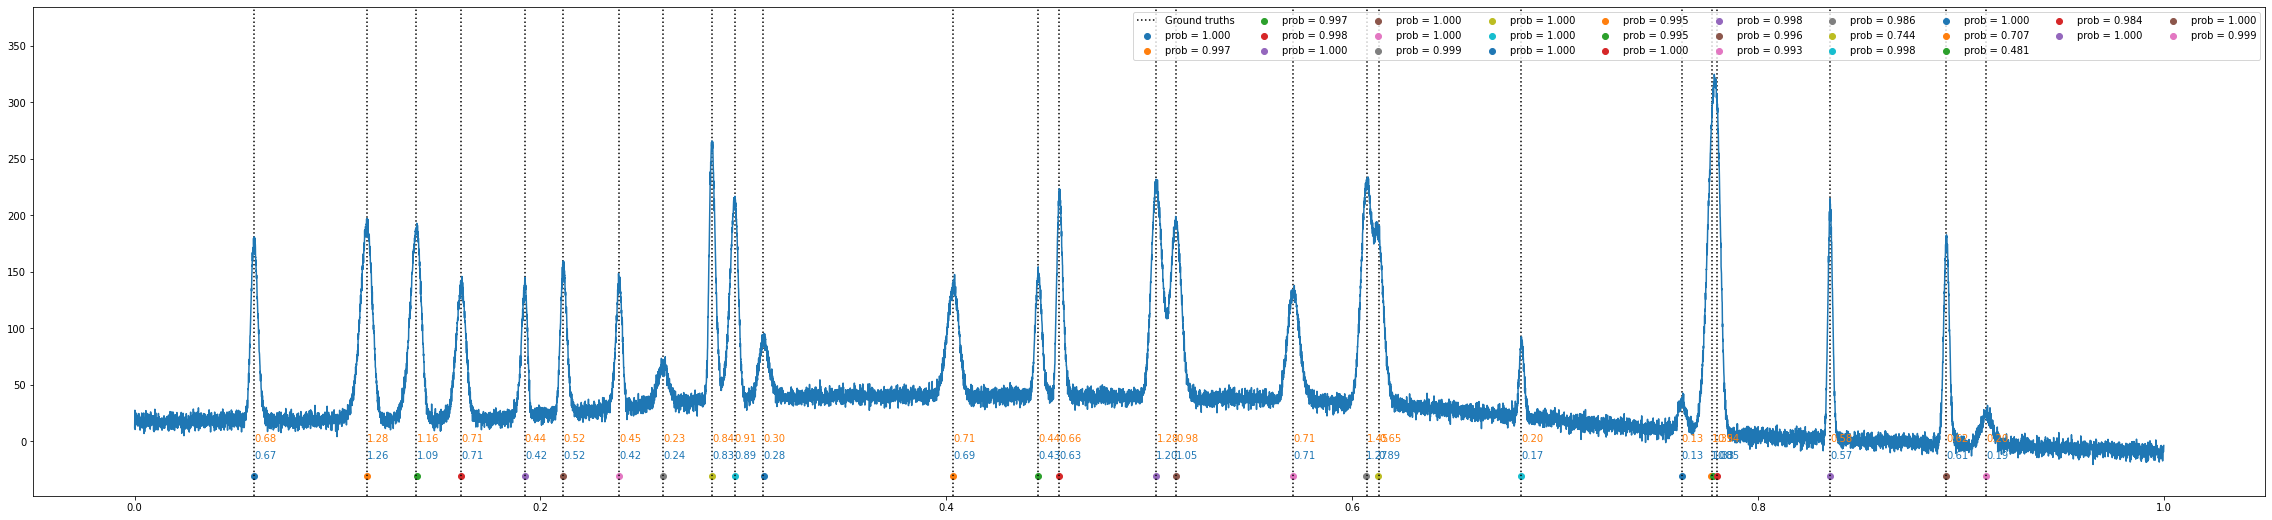

In [57]:
plt.figure(figsize=(40, 9))

ID = 2

# GROUND TRUTH
true = validation_generator.__getitem__(ID)

x = true[0][0]
x = x.reshape((-1))
y = true[1][0]
y = y.reshape((-1, 3))

gt = encoder.decode(y)
for i, (l, a) in enumerate(zip(gt[1], gt[2])):
    if i == 0:
        label = 'Ground truths'
    else:
        label = None
    plt.axvline(l, color='black', linestyle=':', label=label)
    plt.text(x=l, y=0, s=f"{a:.2f}", color="C1")
    #plt.plot([l, l], [0, a], color='C1', linewidth=4)
    #plt.plot([l-s/2, l+s/2], [0, 0], color='C1', linewidth=4)

# PREDICTIONS


probs, locs, areas = encoder.decode(prediction[ID*validation_generator.batch_size], 0.35)
for i, (p, l, a) in enumerate(zip(probs, locs, areas)):
    plt.scatter(l, np.min(x)-10, label=f'prob = {p:.3f}', c=f'C{i}')
    #plt.plot([l-w/2, l+w/2], [.080+(i*.015), .080+(i*.015)], color=f'C{i}')
    #plt.plot([l, l], [0, a], color='C0', linewidth=4, linestyle=':')
    #plt.plot([l-s/2, l+s/2], [0, 0], color='C0', linewidth=4, linestyle=':')
    plt.text(x=l, y=-15, s=f"{a:.2f}", color='C0')
    
# CHROMATOGRAM
plt.plot(np.linspace(0, 1, simulator.resolution), x)

plt.ylim(None, np.max(x)+60)
plt.legend(ncol=10)

#plt.xlim(0.6, 0.7)
#for i, _ in enumerate(np.linspace(0, 1, encoder.num_windows+1)):
  # plt.axvline(_, ymin=0.0, ymax=0.1, color='grey', alpha=0.8)
#     plt.text(x = _ + 0.002, y=min(x)*1.2, s=i)
    
#plt.savefig(f'pd_{ID}.png', dpi=300)

In [221]:
encoder.num_windows

1024

In [31]:
true[0]

array([[[-32.18758935],
        [-32.19772819],
        [-36.08065433],
        ...,
        [-50.34018911],
        [-44.96113467],
        [-44.19971608]],

       [[-48.57613598],
        [-47.73288442],
        [-50.57540847],
        ...,
        [-45.42672455],
        [-43.87481871],
        [-42.60541207]],

       [[-40.06055921],
        [-40.87676027],
        [-46.33913848],
        ...,
        [  1.68150951],
        [  3.21576122],
        [  0.47553527]],

       ...,

       [[191.3946352 ],
        [188.26387053],
        [189.69187009],
        ...,
        [ -2.18885001],
        [ -0.99118109],
        [ -2.59180514]],

       [[ -3.06356074],
        [ -3.46213054],
        [ -3.99050632],
        ...,
        [ -3.72514013],
        [ -4.44954436],
        [ -6.81041236]],

       [[ -3.57863307],
        [ -6.94536456],
        [ -6.3988929 ],
        ...,
        [-13.59781514],
        [-10.73318887],
        [-13.97258437]]])

In [62]:
class TemperatureSoftmaxCalibration(tf.keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.temperature = tf.Variable(1., trainable=True)
    
    def call(self, inputs):
        z = inputs / self.temperature
        p = tf.nn.sigmoid(z)
        return p
    
# class TemperatureSoftmaxCalibration(tf.keras.Model):
    
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.a = tf.Variable(1., trainable=True)
#         self.b = tf.Variable(0., trainable=True)
    
#     def call(self, inputs):
#         z = self.a * inputs + self.b
#         p = tf.nn.sigmoid(z)
#         return p
    
calib = TemperatureSoftmaxCalibration()

calib.compile(loss='bce', optimizer=tf.keras.optimizers.Adam(1e-2))

predictions = model.predict(x_validation)

preds = predictions[:, :, 0]
preds = tf.math.log(preds/(1-preds+1e-7))

trues = y_validation[:, :, 0],

calib.fit(preds, trues, epochs=100, verbose=2)

Epoch 1/100
32/32 - 0s - loss: 0.0744
Epoch 2/100
32/32 - 0s - loss: 0.0744
Epoch 3/100
32/32 - 0s - loss: 0.0744
Epoch 4/100
32/32 - 0s - loss: 0.0744
Epoch 5/100
32/32 - 0s - loss: 0.0744
Epoch 6/100
32/32 - 0s - loss: 0.0744
Epoch 7/100
32/32 - 0s - loss: 0.0744
Epoch 8/100
32/32 - 0s - loss: 0.0744
Epoch 9/100
32/32 - 0s - loss: 0.0744
Epoch 10/100
32/32 - 0s - loss: 0.0744
Epoch 11/100
32/32 - 0s - loss: 0.0744
Epoch 12/100
32/32 - 0s - loss: 0.0744
Epoch 13/100
32/32 - 0s - loss: 0.0744
Epoch 14/100
32/32 - 0s - loss: 0.0744
Epoch 15/100
32/32 - 0s - loss: 0.0744
Epoch 16/100
32/32 - 0s - loss: 0.0744
Epoch 17/100
32/32 - 0s - loss: 0.0744
Epoch 18/100
32/32 - 0s - loss: 0.0744
Epoch 19/100
32/32 - 0s - loss: 0.0744
Epoch 20/100
32/32 - 0s - loss: 0.0744
Epoch 21/100
32/32 - 0s - loss: 0.0744
Epoch 22/100
32/32 - 0s - loss: 0.0744
Epoch 23/100
32/32 - 0s - loss: 0.0744
Epoch 24/100
32/32 - 0s - loss: 0.0744
Epoch 25/100
32/32 - 0s - loss: 0.0744
Epoch 26/100
32/32 - 0s - loss: 0.

In [68]:
a = np.array([0.1, 0.01, 0.02, 0.01, 0.005])**0.5

a / a.sum()

array([0.43416422, 0.13729478, 0.19416414, 0.13729478, 0.09708207])

In [44]:
x_validation, y_validation = x[:1000], y[:1000]

In [63]:
calib.trainable_weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.9883287>]

In [64]:
new_preds = calib.predict(preds)
new_preds[0][50:250]

array([0.9999999 , 0.01315162, 0.00089292, 0.02007515, 0.00584528,
       0.00687139, 0.01121641, 0.999027  , 0.00456587, 0.00458048,
       0.00555036, 0.00110206, 0.97817916, 0.9656225 , 0.07587819,
       0.00085719, 0.18936278, 0.9999999 , 0.00890169, 0.00502496,
       0.00666814, 0.00969114, 0.00625463, 0.9926225 , 0.00947756,
       0.0071947 , 0.00452559, 0.01128044, 0.00528503, 0.00898242,
       0.9914322 , 0.08296558, 0.00495082, 0.00774186, 0.00524516,
       0.9473183 , 0.01017711, 0.97146803, 0.99999905, 0.00384132,
       0.00556372, 0.01365208, 0.9999999 , 0.00087566, 0.9999999 ,
       0.07077321, 0.00650791, 0.9999999 , 0.01482556, 0.0004111 ,
       0.0820742 , 0.9999999 , 0.00171471, 0.9999999 , 0.00919203,
       0.0066893 , 0.99999976, 0.03940739, 0.0018126 , 0.04514566,
       0.00239178, 0.7494513 , 0.5612319 , 0.9996743 , 0.00361779,
       0.0107372 , 0.09755078, 0.99999833, 0.00499584, 0.00401576,
       0.0043205 , 0.00038904, 0.00273332, 0.88775706, 0.08973

In [65]:
tf.nn.sigmoid(preds)[0][50:250]

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0.9999999 , 0.01382201, 0.00096908, 0.02098755, 0.00620416,
       0.00727907, 0.01181126, 0.99894506, 0.00486058, 0.00487595,
       0.00589481, 0.00119311, 0.97721136, 0.9643066 , 0.07794944,
       0.00093076, 0.19198178, 0.9999999 , 0.00940029, 0.00534316,
       0.00706632, 0.01022336, 0.00663324, 0.9921915 , 0.01000077,
       0.00761733, 0.00481821, 0.01187785, 0.0056163 , 0.00948449,
       0.99094814, 0.08512424, 0.00526527, 0.00818936, 0.00557445,
       0.94560975, 0.0107296 , 0.9703043 , 0.9999988 , 0.00409771,
       0.00590882, 0.01434135, 0.9999999 , 0.00095057, 0.9999999 ,
       0.07277525, 0.00689855, 0.9999999 , 0.01555819, 0.00045024,
       0.08422241, 0.9999999 , 0.00184674, 0.9999999 , 0.0097031 ,
       0.00708847, 0.99999964, 0.04084283, 0.00195089, 0.04670613,
       0.00256582, 0.74704236, 0.5605243 , 0.99964225, 0.00386202,
       0.01131269, 0.09986067, 0.999998  , 0.00531257, 0.00428152,
       0.00460

array([], dtype=float32)

In [28]:
import tensorflow_probability as tfp

tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(tf.nn.sigmoid(preds), (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(tf.nn.sigmoid(preds), (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732813>

In [22]:
tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(new_preds, (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(new_preds, (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732815>

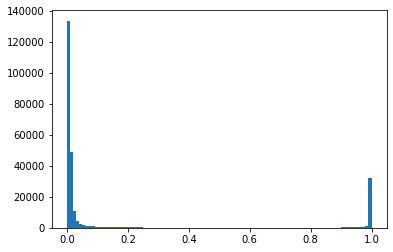

In [26]:
plt.hist(tf.reshape(new_preds, (-1)), bins=100);

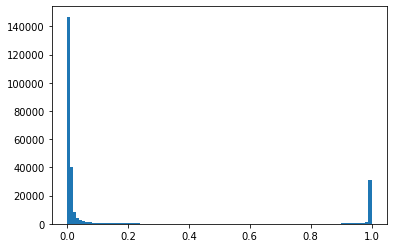

In [29]:
plt.hist(tf.reshape(tf.nn.sigmoid(preds), (-1)), bins=100);